<a href="https://colab.research.google.com/github/stgkrt/ReinforcementLearning/blob/main/RL_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モンテカルロ法


〇モンテカルロ法
とりあえず適当に動いてみる。その時の結果から報酬を経験として蓄積していく。

*   ゲームをやってみた結果、もらった報酬をもとに価値計算
*   今回の価値はQ(s,a)で表される

> Q(s,a)は、「状態sで行動aをしたときに、ゲーム終了までに得られる報酬」
$$ G_t = r_{t+1} + r_{t+2} + r_{t+2} + \dots + r_{T} $$

> 未来でもらえる報酬は不確かな値なので、”割引率”$\gamma$ をかける
$$ G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+2} + \dots + \gamma^{T-t-1} r_{T} $$

> これを"割引現在価値"という
$$ Q(s,a) ← Q(s,a) + \alpha (G_t - Q(s,a))  $$
状態sから、その時点での報酬をQ(s,a)として予測する。これに対して、ゲーム全体で得られた報酬をGtとの差を考える。
これに学習率αをかけたものとして、次のQ(s,a)として学習する。
αは0~1の値をとるハイパーパラメータ。Qの値が変化しなくなると学習終了。

モンテカルロ法では、状態遷移の確率を事前に設定する必要がない。

（実際に遷移確率はわからないことも多い）


In [ ]:
import gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
env = gym.make("FrozenLake-v0",is_slippery=False)#is_flippery=Falseで意図しない方向にスリップすることをなくす＝意図した方向に移動できる
env.render()


SFFF
FHFH
FFFH
HFFG


In [ ]:
class MonteCarlo:
    def __init__(self, env):
        self.env = env
        self.Q = {}
        self.initialize()
        self.reward_log = []
    
    def initialize(self):
        for s in range(self.env.nS):
            self.Q[s] = [0] * self.env.nA#すべての状態に対する報酬を0として初期化する
        self.env.reset()

    def policy(self, s, epsilon = 0.1):
        if np.random.random() < epsilon:
            # print("explore---------")
            return np.random.randint(self.env.nA)
        else:
            if sum(self.Q[s]) == 0:
                return np.random.randint(self.env.nA)
            else:
                return np.argmax(self.Q[s])

    def learn(self, episode_count=1000, gamma=0.9, alpha=0.8):
        for e in range(episode_count):
            env.reset()
            done = False
            experience_log = []   
            s = 0 
            while not done:
                # a = np.random.randint(self.env.nA)
                a = self.policy(s)
                next_s, reward, done , _ = self.env.step(a)
                experience_log.append({'state':s, 'action':a, 'reward':reward})
                s = next_s
            else:
                # print("episode_num:",e)
                # self.env.render()
                self.reward_log.append(reward)
            
            for t , experience in enumerate(experience_log):
                G = 0
                i = 0
                for j in range(t, len(experience_log)):
                    G += (gamma**i)*experience_log[j]['reward']
                    i += 1
                s = experience['state']
                a = experience['action']
                self.Q[s][a] += alpha*(G - self.Q[s][a])
        # return self.Q
        return self.reward_log
    
    def show_rewards(self, interval = 50):
        average_rewards = {}
        for e in range(0, len(self.reward_log), interval):
            average_rewards[e] = np.mean(self.reward_log[e:e+50])
        return pd.Series(average_rewards)

In [ ]:
mc = MonteCarlo(env)
test = mc.learn()

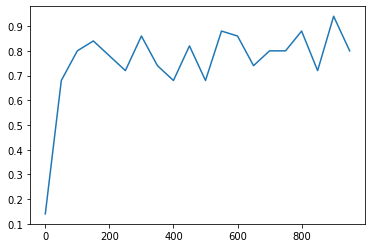

In [ ]:
mc.show_rewards().plot()

動的計画法

In [ ]:
class Planner:
    def __init__(self,env):
        self.env = env

    def s_to_loc(self,s):
        row = s // self.env.ncol
        col = s % self.env.ncol
        return row,col
    
    def reward(self,s):
        row, col = self.s_to_loc(s)
        if self.env.desc[row][col] == b'H':
            return -1
        elif self.env.desc[row][col] == b'G':
            return 1
        else:
            return 0
    
    def plan(self, gamma=0.9, threshold=0.0001):
        self.env.reset()
        V = {}
        for s in range(self.env.nS):
            V[s] = self.reward(s)
        while True:
            delta = 0
            for s in V:
                row, col = self.s_to_loc(s)
                if self.env.desc[row][col] in [b'H', b'G']:
                    continue
                expected_rewards = []
                for a in range(self.env.nA):
                    r = 0
                    for prob, next_s, _, _ in self.env.P[s][a]:
                        r += gamma * prob * V[next_s]
                    expected_rewards.append(r)
                max_reward = max(expected_rewards)
                new_V = self.reward(s) + max_reward

                # | V_i+1  - V_i |
                delta = max(delta, abs(new_V - V[s]))
                V[s] = new_V

            if delta < threshold:
                break
        
        return self.dict_to_grid(V)
    
    def dict_to_grid(self, V):
        grid = []
        for i in range(self.env.nrow):
            row = [0] * self.env.ncol
            grid.append(row)
        for s in V:
            row, col = self.s_to_loc(s)
            grid[row][col] = V[s]
        return pd.DataFrame(grid)

In [ ]:
pl = Planner(env)
pl.plan()

,0,1,2,3
0,0.045684,0.026631,0.016628,0.01234
1,0.061139,-1.000000,-0.252228,-1.00000
2,0.097082,0.165458,0.142632,-1.00000
3,-1.000000,0.311850,0.562218,1.00000
